In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score
import fatf.utils.metrics.tools as fatf_metric_tools
import fatf.utils.metrics.metrics as fatf_performance_metrics
import fatf.utils.data.tools as fatf_data_tools
import fatf.utils.metrics.tools as fatf_mt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=Warning)


25-Oct-27 12:16:33 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [2]:
train_data = pd.read_csv("../data/train_imputed.csv")
test_data = pd.read_csv("../data/test_imputed.csv")

In [3]:
categorical_features = ['admission_type','insurance', 'language', 'marital_status', 'race', 'gender','anchor_age']
target_column = 'hospital_expire_flag' 

X_train_data = train_data.drop(columns=[target_column])
y_train_data = train_data[target_column]
X_test_data = test_data.drop(columns=[target_column])
y_test_data = test_data[target_column]

# Separate categorical and numerical columns
X_train_cat = X_train_data[categorical_features]
X_test_cat = X_test_data[categorical_features]

X_train_num = X_train_data.drop(columns=categorical_features)
X_test_num = X_test_data.drop(columns=categorical_features)

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

X_train_final = pd.concat([X_train_num_scaled, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_num_scaled, X_test_cat], axis=1)

In [4]:
encoding_columns = ['insurance', 'language', 'race', 'gender']
train_data_encoded = pd.get_dummies(X_train_final, columns=encoding_columns, prefix=encoding_columns, drop_first=True)
test_data_encoded = pd.get_dummies(X_test_final, columns=encoding_columns, prefix=encoding_columns, drop_first=True)
train_data_encoded.head()

,GCS_Eye_full_missing,GCS_Eye_full_min,GCS_Eye_full_max,GCS_Eye_full_mode,GCS_Eye_full_count,GCS_Eye_first_10_missing,GCS_Eye_first_10_min,GCS_Eye_first_10_max,GCS_Eye_first_10_mode,GCS_Eye_first_10_count,...,insurance_4.0,language_2.0,language_3.0,language_4.0,language_5.0,race_2.0,race_3.0,race_4.0,race_5.0,gender_2.0
0,0.0,-1.245691,0.226471,-2.992028,1.220947,-0.300391,-1.645843,-1.089511,-1.690910,0.791860,...,False,False,False,False,False,False,False,False,False,False
1,0.0,-1.245691,0.226471,0.462360,-0.512524,-0.300391,-1.645843,0.626232,-1.690910,0.122291,...,False,False,False,False,False,False,False,False,False,True
2,0.0,0.320867,0.226471,0.462360,-0.141066,-0.300391,-0.056877,-0.231639,-0.086757,-0.547277,...,False,False,False,False,False,False,False,False,False,False
3,0.0,0.320867,0.226471,0.462360,1.592405,-0.300391,0.737607,0.626232,0.715320,0.791860,...,False,False,False,False,False,True,False,False,False,True
4,0.0,-1.245691,0.226471,-2.992028,-0.017246,-0.300391,-1.645843,0.626232,-1.690910,0.122291,...,False,False,False,False,False,False,False,False,False,False


In [5]:
X_test = test_data_encoded.astype(float).to_numpy()
y_test = y_test_data.to_numpy()


In [6]:
# for linear models
protected_index = X_test_final.columns.get_loc('race')  
x_ins_grouping = X_test_final.to_numpy()
ins_grouping = fatf_data_tools.group_by_column(x_ins_grouping, protected_index, treat_as_categorical=True)
ins_grouping[1]

['(1.0,)', '(2.0,)', '(3.0,)', '(4.0,)', '(5.0,)']

In [7]:
lr = load('../models/lr_2_model.joblib')
lda = load('../models/lda_model.joblib')
nb = load('../models/gnb_model.joblib')
svm = load('../models/final_svm.joblib')
knn = load('../models/KNN_model.joblib')
rf = load('../models/RF_model.joblib')
xg = load('../models/XG_model.joblib')

models = {"lr": lr,  "lda": lda, "nb": nb, "svm":svm, "knn": knn, "rf": rf, "xg": xg}

y_preds = {}
for name, model in models.items():
    
    input = X_test
    y_preds[name] = model.predict(input)

In [8]:
ins_cm_lr = []
ins_cm_lda = []
ins_cm_nb = []
ins_cm_svm = []
ins_cm_knn = []
ins_cm_rf = []
ins_cm_xg = []

cm_lists = {"lr": ins_cm_lr, "lda": ins_cm_lda, "nb": ins_cm_nb, "svm":ins_cm_svm, "knn": ins_cm_knn, "rf": ins_cm_rf, "xg": ins_cm_xg}
ins_masks = ins_grouping[0]

for mask in ins_masks:
    y_true_ins = y_test[mask]
    
    for name in models.keys():
        y_pred = y_preds[name]
        
        if y_pred is None:
            cm = None
        else:
            y_pred_ins = y_pred[mask]
            if len(y_true_ins) == 0:
                cm = None
            else:
                cm = confusion_matrix(y_true_ins, y_pred_ins, labels=[0, 1])
        
        cm_lists[name].append(cm)

In [9]:
# equal accuracy
tolerance = 0.10 
results_rows = []

def compute_accuracy(cm):
    if cm is None or cm.shape != (2, 2):
        return None
    tn, fp, fn, tp = cm.ravel()
    return (tp + tn) / (tp + tn + fp + fn)

for model_name in ["lr", "lda", "nb", "svm", "knn","rf", "xg"]:
    cm_list = globals()[f'ins_cm_{model_name}']  
    for i, cm in enumerate(cm_list):
        subgroup_label = ins_grouping[1][i] 
        acc = compute_accuracy(cm)
        results_rows.append({
            "model": model_name.upper(),
            "subgroup": subgroup_label,
            "accuracy": acc})

accuracy_df = pd.DataFrame(results_rows)
accuracy_df.head()

,model,subgroup,accuracy
0,LR,"(1.0,)",0.941203
1,LR,"(2.0,)",0.923611
2,LR,"(3.0,)",0.904545
3,LR,"(4.0,)",0.924883
4,LR,"(5.0,)",0.932189


In [10]:
bias_rows = []

for model_name in accuracy_df['model'].unique():
    model_df = accuracy_df[accuracy_df['model'] == model_name].reset_index(drop=True)
    n = len(model_df)
    
    for i in range(n):
        for j in range(i + 1, n):
            acc_i = model_df.loc[i, 'accuracy']
            acc_j = model_df.loc[j, 'accuracy']
            group_i = model_df.loc[i, 'subgroup']
            group_j = model_df.loc[j, 'subgroup']
            
            if acc_i is not None and acc_j is not None:
                acc_diff = abs(acc_i - acc_j)
                bias_rows.append({
                    "model": model_name,
                    "subgroup_1": group_i,
                    "subgroup_2": group_j,
                    "accuracy_1": acc_i,
                    "accuracy_2": acc_j,
                    "accuracy_diff": acc_diff,
                    "bias_violation": acc_diff > tolerance
                })

bias_df = pd.DataFrame(bias_rows)
bias_df_true = bias_df[bias_df['bias_violation'] == True]
bias_df_true

,model,subgroup_1,subgroup_2,accuracy_1,accuracy_2,accuracy_diff,bias_violation


In [11]:
# equal opportunity 
tolerance = 0.10
results_rows = []

def compute_tpr(cm):
    if cm is None or cm.shape != (2, 2):
        return None
    tn, fp, fn, tp = cm.ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else None

for model_name in ["lr", "lda", "nb", "svm","knn","rf", "xg"]:
    cm_list = globals()[f'ins_cm_{model_name}'] 
    
    for i, cm in enumerate(cm_list):
        subgroup_label = ins_grouping[1][i] 
        total_subjects = cm.sum()
        tpr = compute_tpr(cm)
        
        results_rows.append({
            "model": model_name.upper(),
            "subgroup": subgroup_label,
            "tpr": tpr})

tpr_df = pd.DataFrame(results_rows)

tpr_df.head()


,model,subgroup,tpr
0,LR,"(1.0,)",0.490050
1,LR,"(2.0,)",0.524590
2,LR,"(3.0,)",0.333333
3,LR,"(4.0,)",0.285714
4,LR,"(5.0,)",0.634146


In [12]:
bias_rows = []

for model_name in tpr_df['model'].unique():
    model_df = tpr_df[tpr_df['model'] == model_name].reset_index(drop=True)
    
    n = len(model_df)
    for i in range(n):
        for j in range(i + 1, n):
            tpr_i = model_df.loc[i, 'tpr']
            tpr_j = model_df.loc[j, 'tpr']
            group_i = model_df.loc[i, 'subgroup']
            group_j = model_df.loc[j, 'subgroup']

            if tpr_i is not None and tpr_j is not None:
                tpr_diff = abs(tpr_i - tpr_j)
                bias_rows.append({
                    "model": model_name,
                    "subgroup_1": group_i,
                    "subgroup_2": group_j,
                    "tpr_1": tpr_i,
                    "tpr_2": tpr_j,
                    "tpr_diff": tpr_diff,
                    "bias_violation": tpr_diff >= tolerance
                })

bias_tpr_df = pd.DataFrame(bias_rows)

bias_tpr_true = bias_tpr_df[bias_tpr_df['bias_violation'] == True]
bias_tpr_true

,model,subgroup_1,subgroup_2,tpr_1,tpr_2,tpr_diff,bias_violation
1,LR,"(1.0,)","(3.0,)",0.490050,0.333333,0.156716,True
2,LR,"(1.0,)","(4.0,)",0.490050,0.285714,0.204335,True
3,LR,"(1.0,)","(5.0,)",0.490050,0.634146,0.144097,True
4,LR,"(2.0,)","(3.0,)",0.524590,0.333333,0.191257,True
5,LR,"(2.0,)","(4.0,)",0.524590,0.285714,0.238876,True
6,LR,"(2.0,)","(5.0,)",0.524590,0.634146,0.109556,True
8,LR,"(3.0,)","(5.0,)",0.333333,0.634146,0.300813,True
9,LR,"(4.0,)","(5.0,)",0.285714,0.634146,0.348432,True
11,LDA,"(1.0,)","(3.0,)",0.500000,0.238095,0.261905,True
12,LDA,"(1.0,)","(4.0,)",0.500000,0.333333,0.166667,True


In [13]:
import matplotlib.colors as plt_colors
cc = plt.get_cmap('Pastel1')
colours = [plt_colors.rgb2hex(cc(i)) for i in range(cc.N)]
cmap_green_red = plt_colors.ListedColormap([colours[2], colours[0]]) 

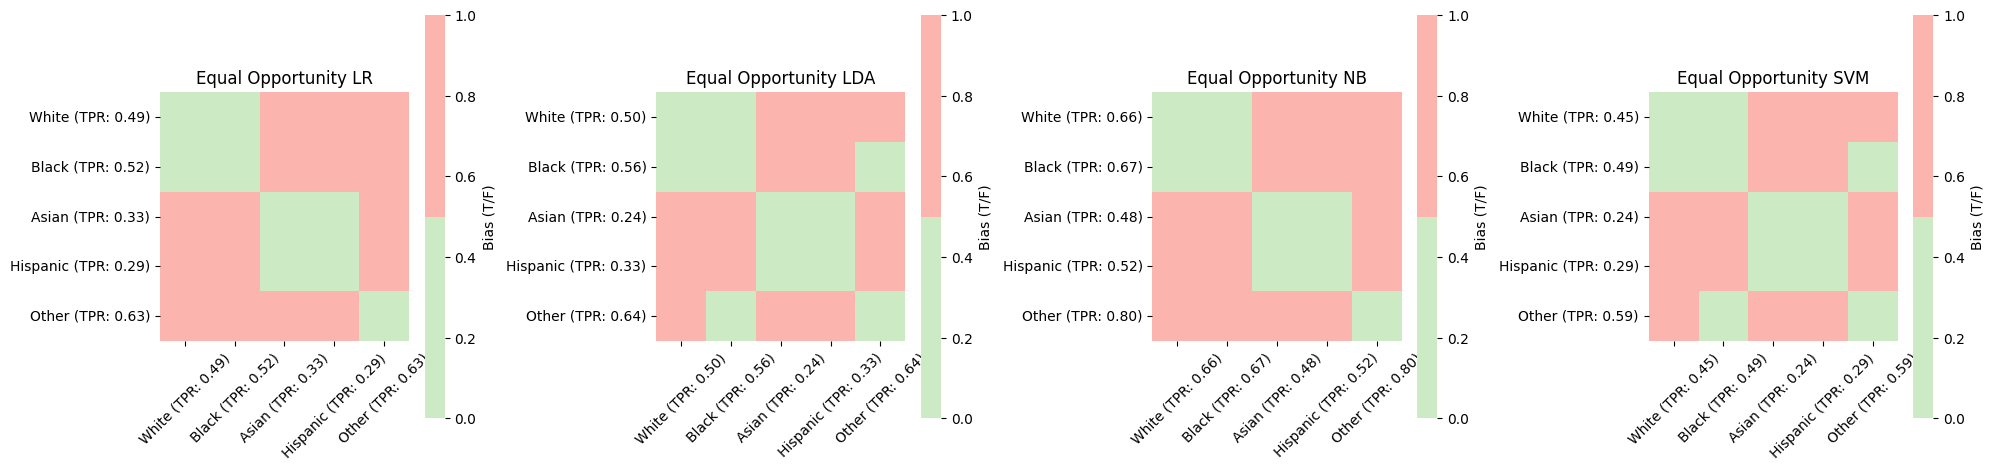

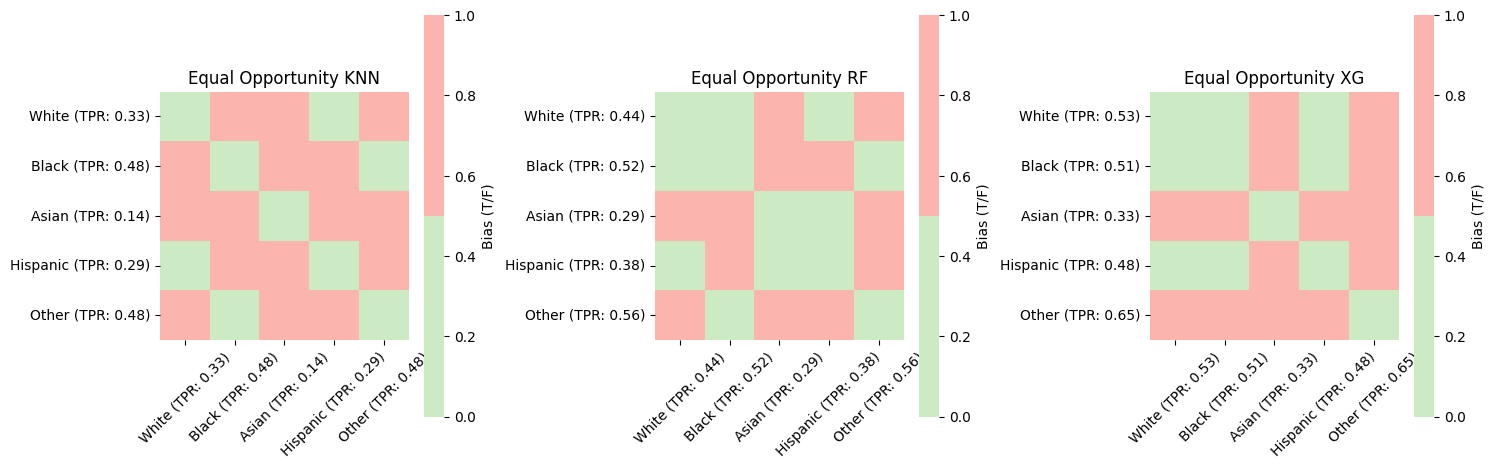

In [26]:
linear_models = ["LR", "LDA",'NB',"SVM"]
nonlinear_models = ["KNN", "RF", "XG"]

insurance_map = {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'}

def map_subgroup_label(label):
    key = int(float(label.strip('(),')))
    return insurance_map.get(key, label) 

def build_bias_matrix_and_labels(model_df):
    tprs = model_df['tpr'].values
    subgroups = model_df['subgroup'].values
    num_subgroups = len(tprs)
    
    bias_matrix = np.zeros((num_subgroups, num_subgroups), dtype=bool)
    
    labeled_subgroups = [f'{map_subgroup_label(sg)} (TPR: {tpr:.2f})' for sg, tpr in zip(subgroups, tprs)]
    
    for i in range(num_subgroups):
        for j in range(num_subgroups):
            if abs(tprs[i] - tprs[j]) >= tolerance:
                bias_matrix[i, j] = True
                
    return bias_matrix, labeled_subgroups

def plot_model_group(models_group, tpr_df, title_prefix):
    num_models = len(models_group)
    fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 5), squeeze=False)
    
    for idx, model_name in enumerate(models_group):
        ax = axes[0, idx]
        model_df = tpr_df[tpr_df['model'] == model_name].reset_index(drop=True)
        
        bias_matrix, labels = build_bias_matrix_and_labels(model_df)
        
        sns.heatmap(
            bias_matrix,
            square=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=cmap_green_red,
            cbar_kws={'label': 'Bias (T/F)'},
            vmin=0, vmax=1, center=0.5,
            ax=ax
        )
        
        ax.set_title(f'{title_prefix} {model_name}', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.show()

plot_model_group(linear_models, tpr_df, title_prefix="Equal Opportunity")

plot_model_group(nonlinear_models, tpr_df, title_prefix="Equal Opportunity")

Saved figure: linear_models_bias_race_Equal_Opportunity.pdf


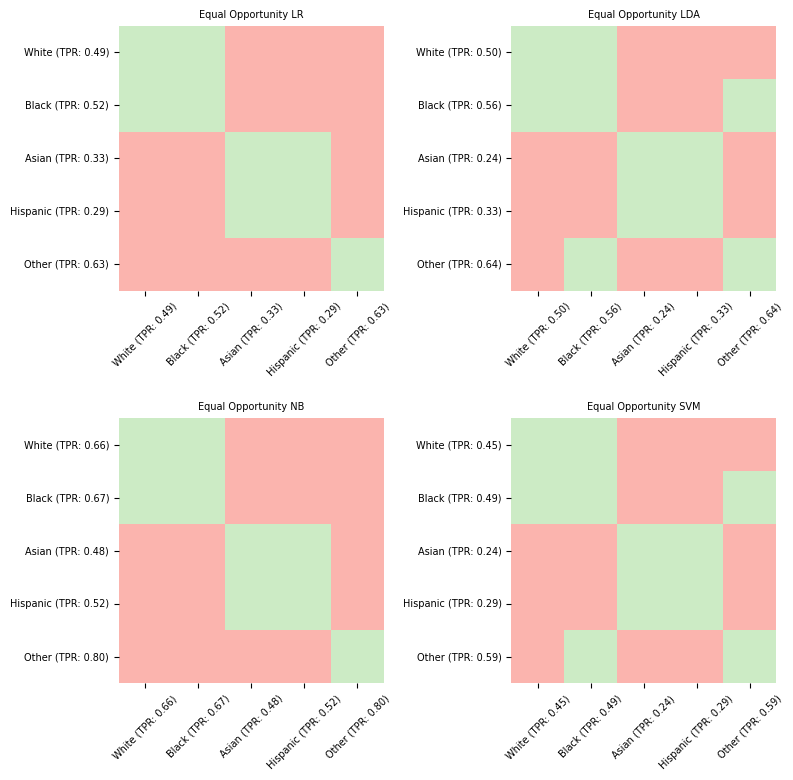

Saved figure: non_linear_models_bias_race_Equal_Opportunity.pdf


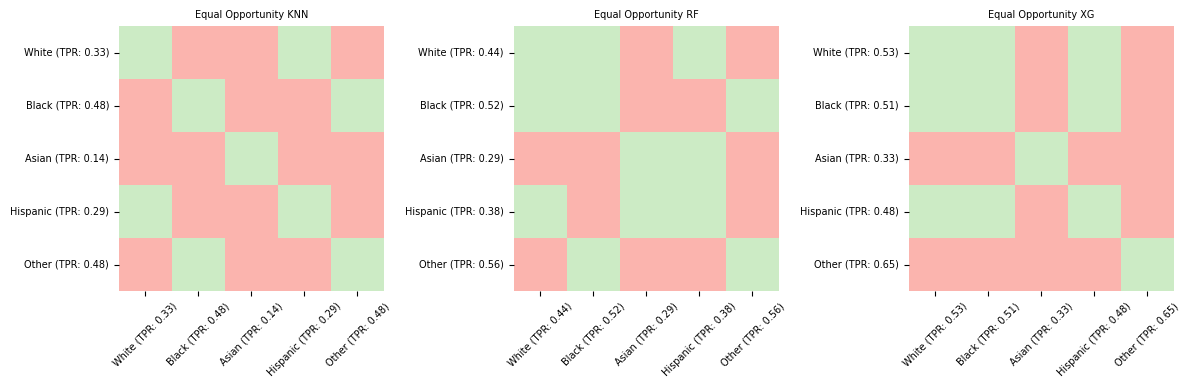

In [18]:
linear_models = ["LR", "LDA",'NB','SVM']
nonlinear_models = ["KNN", "RF", "XG"]

race_map = {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'}

def map_subgroup_label(label):
    key = int(float(label.strip('(),')))
    return race_map.get(key, label)

def build_bias_matrix_and_labels(model_df):
    tprs = model_df['tpr'].values
    subgroups = model_df['subgroup'].values
    num_subgroups = len(tprs)
    
    bias_matrix = np.zeros((num_subgroups, num_subgroups), dtype=bool)
    
    labeled_subgroups = [f'{map_subgroup_label(sg)} (TPR: {tpr:.2f})' for sg, tpr in zip(subgroups, tprs)]
    
    for i in range(num_subgroups):
        for j in range(num_subgroups):
            if abs(tprs[i] - tprs[j]) >= tolerance:
                bias_matrix[i, j] = True
                
    return bias_matrix, labeled_subgroups


def plot_model_group(models_group, tpr_df, title_prefix, save_path=None, layout=(1, None)):
    num_models = len(models_group)
    
    if layout == (1, None):
        nrows = 1
        ncols = num_models
    else:
        nrows, ncols = layout
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = np.array(axes).reshape(-1)  
    
    for idx, model_name in enumerate(models_group):
        ax = axes[idx]
        model_df = tpr_df[tpr_df['model'] == model_name].reset_index(drop=True)
        
        bias_matrix, labels = build_bias_matrix_and_labels(model_df)
        
        sns.heatmap(
            bias_matrix,
            square=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=cmap_green_red,
            cbar=False,
            vmin=0, vmax=1, center=0.5,
            ax=ax
        )
        ax.set_title(f'{title_prefix} {model_name}', fontsize=7)
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        ax.tick_params(axis='y', labelsize=7)
    
    for extra_ax in axes[num_models:]:
        extra_ax.axis('off')
    
    plt.tight_layout()
    
    if save_path is not None:
        fig_filename = f"{save_path}_{title_prefix.replace(' ','_')}.pdf"
        fig.savefig(fig_filename, bbox_inches='tight', dpi=300)
        print(f"Saved figure: {fig_filename}")
    
    plt.show()


# Linear models in 2x2 grid
plot_model_group(linear_models, tpr_df, title_prefix="Equal Opportunity", 
                 save_path="linear_models_bias_race", layout=(2, 2))

# Non-linear models in one row
plot_model_group(nonlinear_models, tpr_df, title_prefix="Equal Opportunity", 
                 save_path="non_linear_models_bias_race", layout=(1, 3))

In [27]:
# demographic parity 
tolerance = 0.10
results_rows = []

def compute_dp_rate(cm):
    if cm is None or cm.shape != (2, 2):
        return None
    tn, fp, fn, tp = cm.ravel()
    total_predictions = tp + fp + tn + fn
    if total_predictions == 0:
        return None
    positive_predictions = tp + fp
    return positive_predictions / total_predictions

for model_name in ["lr",  "lda", "nb", "svm", "knn","rf", "xg"]:
    cm_list = globals()[f'ins_cm_{model_name}']  
    
    for i, cm in enumerate(cm_list):
        subgroup_label = ins_grouping[1][i] 
        dp_rate = compute_dp_rate(cm)
        results_rows.append({
            "model": model_name.upper(),
            "subgroup": subgroup_label,
            "dp_rate": dp_rate
        })

dp_df = pd.DataFrame(results_rows)
dp_df.head()


,model,subgroup,dp_rate
0,LR,"(1.0,)",0.057016
1,LR,"(2.0,)",0.081597
2,LR,"(3.0,)",0.063636
3,LR,"(4.0,)",0.032864
4,LR,"(5.0,)",0.105579


In [28]:
bias_rows = []

for model_name in dp_df['model'].unique():
    model_df = dp_df[dp_df['model'] == model_name].reset_index(drop=True)
    n = len(model_df)
    
    for i in range(n):
        for j in range(i + 1, n):
            dp_i = model_df.loc[i, 'dp_rate']
            dp_j = model_df.loc[j, 'dp_rate']
            group_i = model_df.loc[i, 'subgroup']
            group_j = model_df.loc[j, 'subgroup']
            
            if dp_i is not None and dp_j is not None:
                dp_diff = abs(dp_i - dp_j)
                bias_rows.append({
                    "model": model_name,
                    "subgroup_1": group_i,
                    "subgroup_2": group_j,
                    "dp_rate_1": dp_i,
                    "dp_rate_2": dp_j,
                    "dp_diff": dp_diff,
                    "bias_violation": dp_diff >= tolerance
                })

bias_dp_df = pd.DataFrame(bias_rows)
bias_dp_true = bias_dp_df[bias_dp_df['bias_violation'] == True]
bias_dp_true

,model,subgroup_1,subgroup_2,dp_rate_1,dp_rate_2,dp_diff,bias_violation


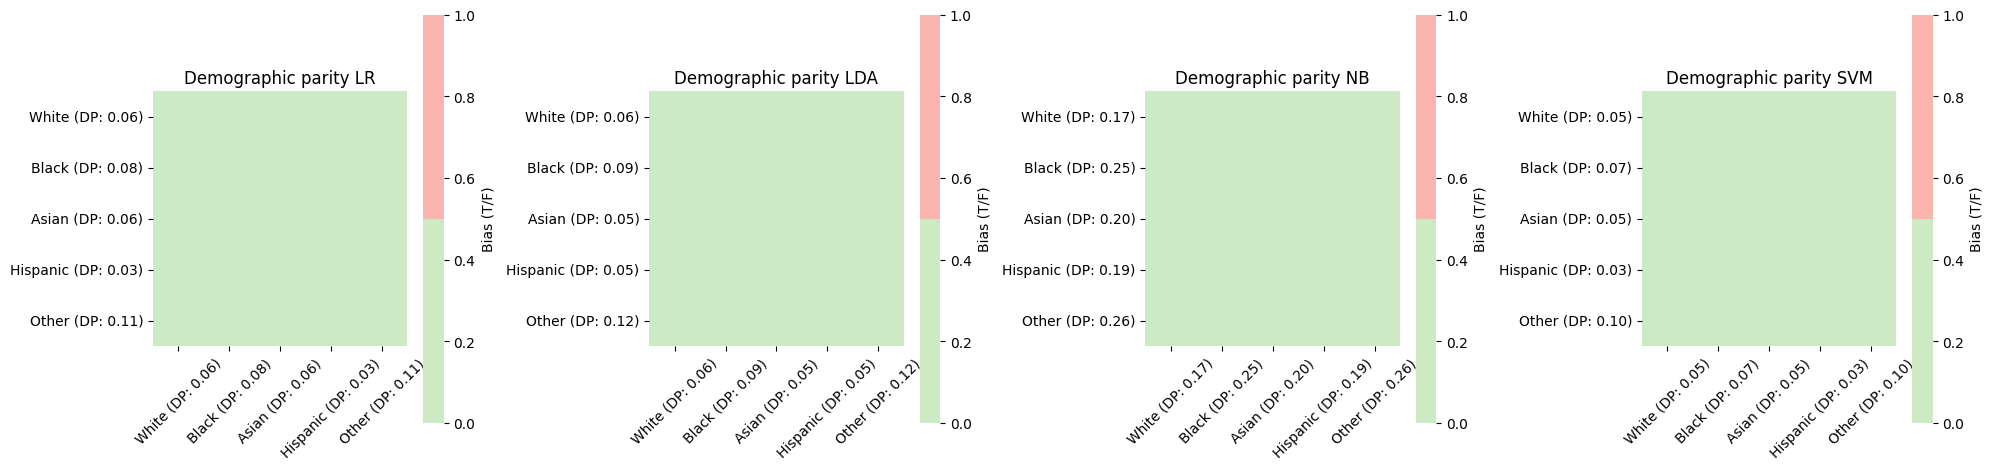

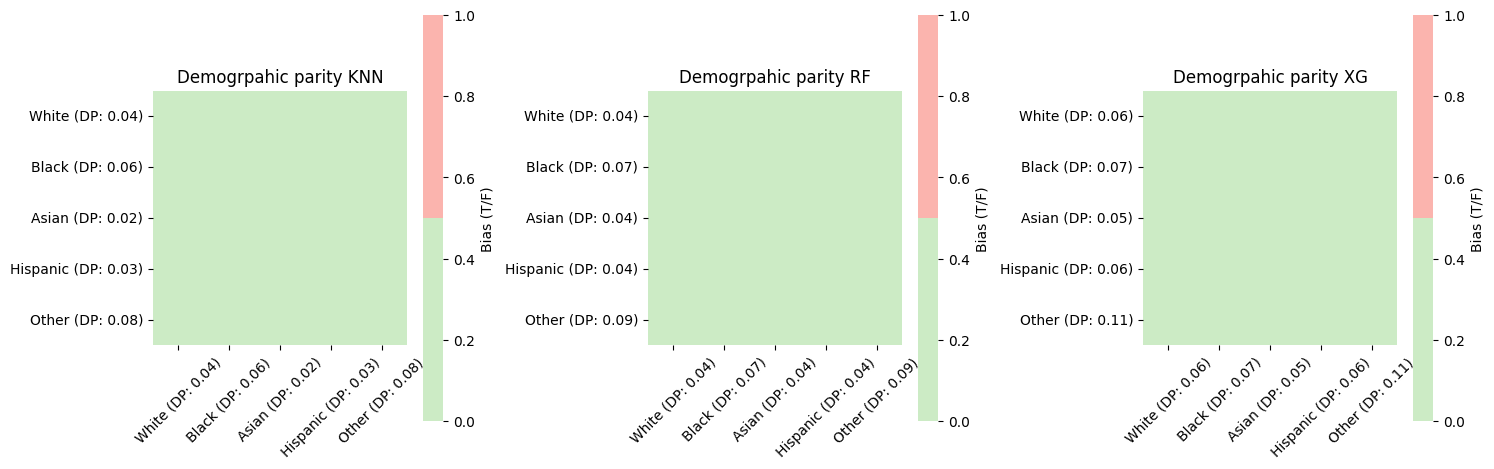

In [29]:
linear_models = ["LR", "LDA",'NB',"SVM"]
nonlinear_models = ["KNN", "RF", "XG"]

insurance_map = {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'}

def map_subgroup_label(label):
    key = int(float(label.strip('(),')))
    return insurance_map.get(key, label) 

def build_bias_matrix_and_labels(model_df):
    dps = model_df['dp_rate'].values
    subgroups = model_df['subgroup'].values
    num_subgroups = len(dps)
    
    bias_matrix = np.zeros((num_subgroups, num_subgroups), dtype=bool)
    
    labeled_subgroups = [f'{map_subgroup_label(sg)} (DP: {dps:.2f})' for sg, dps in zip(subgroups, dps)]
    
    for i in range(num_subgroups):
        for j in range(num_subgroups):
            if abs(dps[i] - dps[j]) >= tolerance:
                bias_matrix[i, j] = True
                
    return bias_matrix, labeled_subgroups

def plot_model_group(models_group, tpr_df, title_prefix):
    num_models = len(models_group)
    fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 5), squeeze=False)
    
    for idx, model_name in enumerate(models_group):
        ax = axes[0, idx]
        model_df = dp_df[dp_df['model'] == model_name].reset_index(drop=True)
        
        bias_matrix, labels = build_bias_matrix_and_labels(model_df)
        
        sns.heatmap(
            bias_matrix,
            square=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=cmap_green_red,
            cbar_kws={'label': 'Bias (T/F)'},
            vmin=0, vmax=1, center=0.5,
            ax=ax
        )
        
        ax.set_title(f'{title_prefix} {model_name}', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.show()

plot_model_group(linear_models, tpr_df, title_prefix="Demographic parity")

plot_model_group(nonlinear_models, tpr_df, title_prefix="Demogrpahic parity")